In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)
# Create Dataframe
df = pd.read_csv("/Users/kanayojustice/Documents/Data_scientist_projects/REAIM/research/data/processed/stage1_preprocessed_data.csv")

# Print shape of dataset
print(df.shape)

(31, 14)


In [3]:
##these are the features with nan value
features_with_na=[features for features in df.columns if df[features].isnull().sum()>=1]
for feature in features_with_na:
    print(feature,np.round(df[feature].isnull().mean()*100,5), '% missing values')

# Feature Engineering

In [4]:
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Num of Numerical Features :', len(num_features))

Num of Numerical Features : 14


In [5]:
discrete_features=[feature for feature in num_features if len(df[feature].unique())<=25]
print('Num of Discrete Features :',len(discrete_features))

Num of Discrete Features : 4


In [6]:
continuous_features=[feature for feature in num_features if feature not in discrete_features]
print('Num of Continuous Features :',len(continuous_features))

Num of Continuous Features : 10


# Multicollinearity check

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def compute_vif(considered_features, df):
    
    X = df[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [8]:
compute_vif(num_features, df)

,Variable,VIF
0,Year,579.267860
1,Energy from renewable & waste sources,11563.489515
2,Total energy consumption of primary fuels and ...,40.156325
3,Fraction from renewable sources and waste,1146.470125
4,Hydroelectric power,2.484033
5,"Wind, wave, tidal",1800.849515
6,Landfill gas,325.281165
7,Sewage gas,100.409938
8,Municipal solid waste (MSW),1103.404423
9,Poultry litter,17.498892


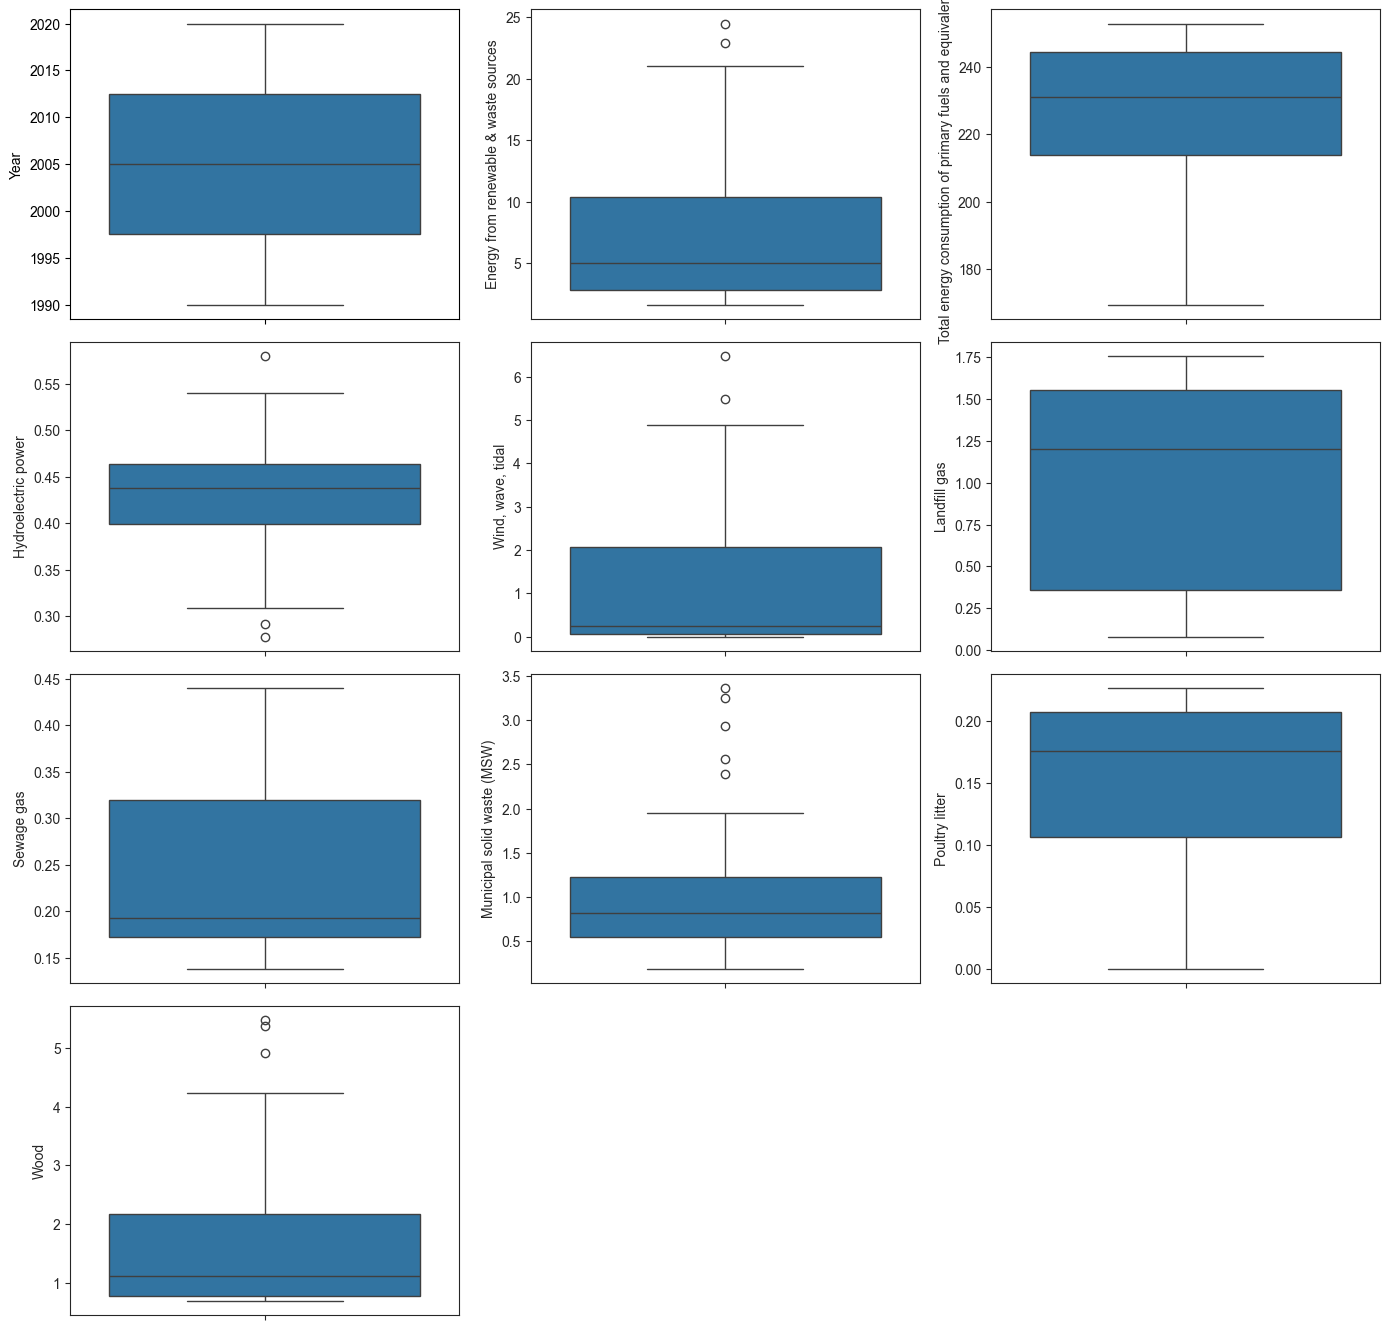

In [9]:
plt.figure(figsize=(14,20))

for i in range(len(continuous_features)):
        plt.subplot(6, 3, i+1)
        sns.set_style('ticks')
        ax = sns.boxplot(df[continuous_features[i]])
        plt.tight_layout()

In [10]:
# Capping it and not trimming it.

def detect_outliers(col):
    # Finding the IQR
    percentile25 = df[col].quantile(0.25)
    percentile75 = df[col].quantile(0.75)
    print('\n ####', col , '####')
    print("percentile25",percentile25)
    print("percentile75",percentile75)
    iqr = percentile75 - percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    print("Upper limit",upper_limit)
    print("Lower limit",lower_limit)
    df.loc[(df[col]>upper_limit), col]= upper_limit
    df.loc[(df[col]<lower_limit), col]= lower_limit    
    return df

In [11]:
for col in continuous_features:
          detect_outliers(col)


 #### Year ####
percentile25 1997.5
percentile75 2012.5
Upper limit 2035.0
Lower limit 1975.0

 #### Energy from renewable & waste sources ####
percentile25 2.8285
percentile75 10.3805
Upper limit 21.7085
Lower limit -8.4995

 #### Total energy consumption of primary fuels and equivalents ####
percentile25 213.87650000000002
percentile75 244.2685
Upper limit 289.8564999999999
Lower limit 168.28850000000006

 #### Hydroelectric power ####
percentile25 0.399
percentile75 0.4635
Upper limit 0.56025
Lower limit 0.30225

 #### Wind, wave, tidal ####
percentile25 0.065
percentile75 2.0745
Upper limit 5.08875
Lower limit -2.94925

 #### Landfill gas ####
percentile25 0.35950000000000004
percentile75 1.5550000000000002
Upper limit 3.34825
Lower limit -1.4337499999999999

 #### Sewage gas ####
percentile25 0.172
percentile75 0.319
Upper limit 0.5395000000000001
Lower limit -0.04850000000000004

 #### Municipal solid waste (MSW) ####
percentile25 0.549
percentile75 1.221
Upper limit 2.229
Lower

# After outlier treatment

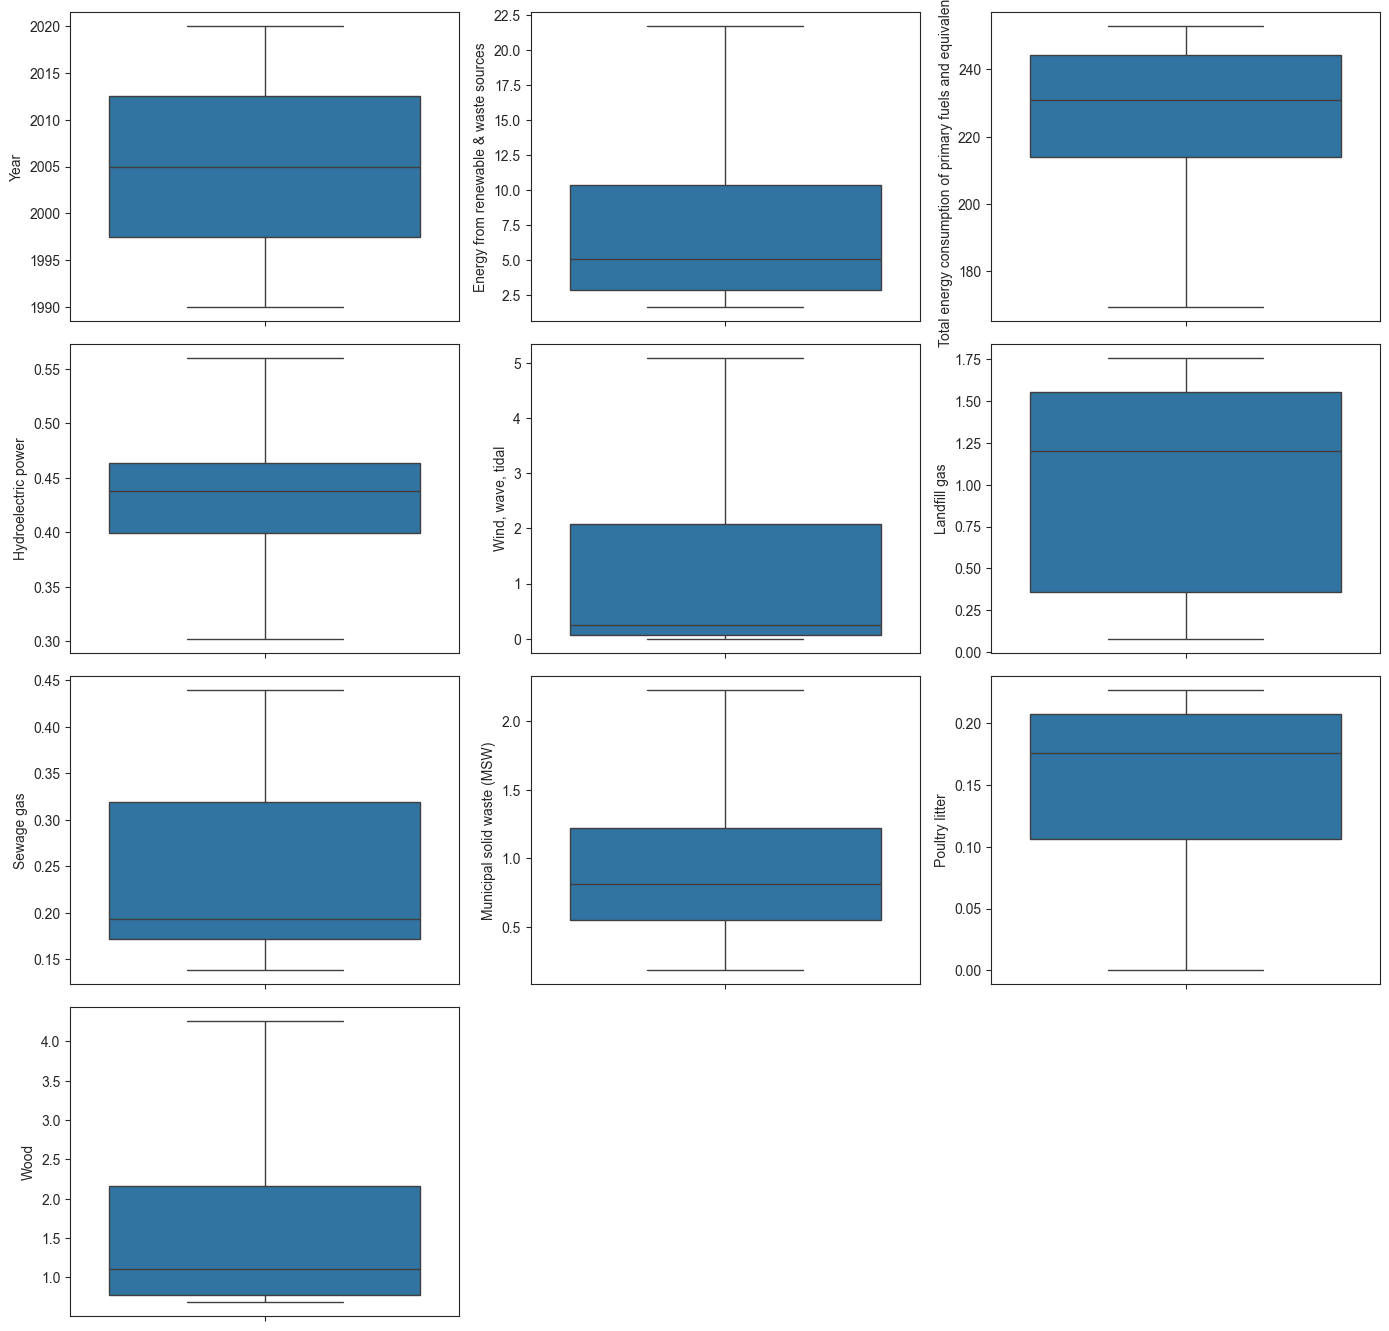

In [12]:
plt.figure(figsize=(14,20))

for i in range(len(continuous_features)):
        plt.subplot(6, 3, i+1)
        sns.set_style('ticks')
        ax = sns.boxplot(df[continuous_features[i]])
        plt.tight_layout()

# Feature scaling

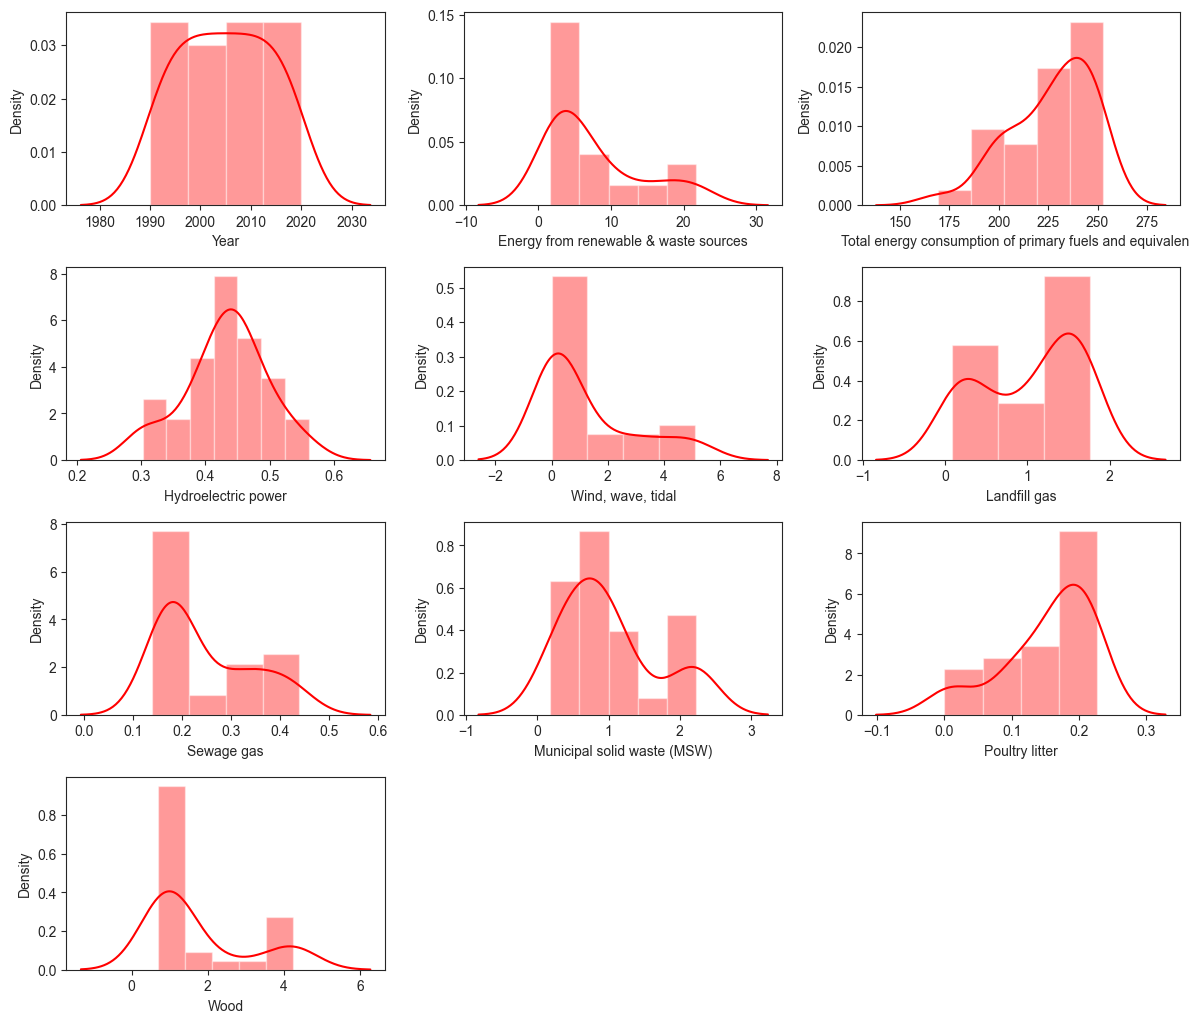

In [13]:
# distribution of data before scaling
plt.figure(figsize=(12, 15))

for i in range(len(continuous_features)):
    plt.subplot(6, 3, i+1)
    sns.distplot(x=df[continuous_features[i]], color='r')
    plt.xlabel(continuous_features[i])
    plt.tight_layout()

# Power scaling

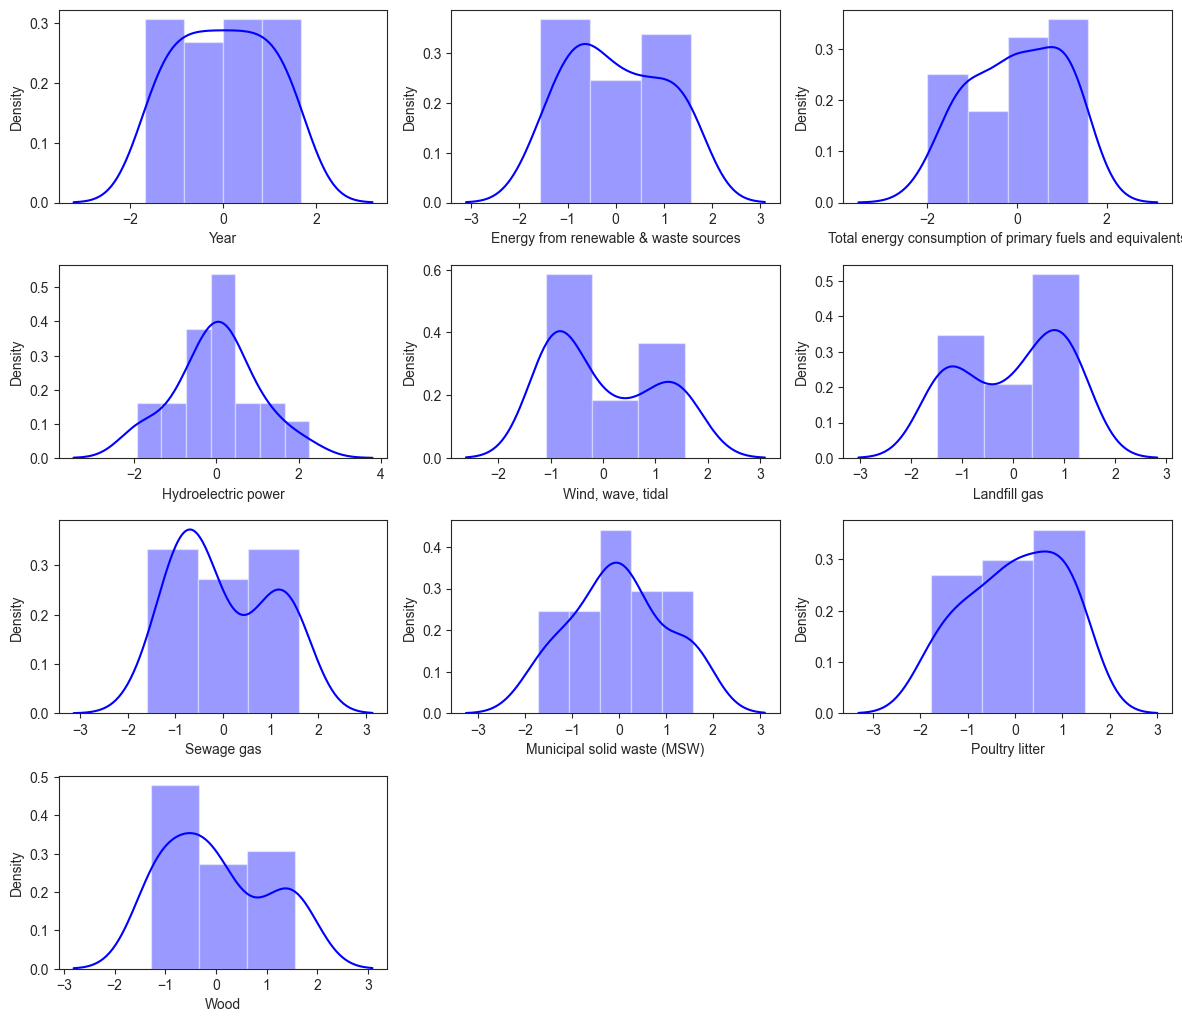

In [14]:
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
dfscaled = df.copy()
dfscaled[:] = PowerTransformer().fit_transform(dfscaled)
plt.figure(figsize=(12, 15))
for i in range(len(continuous_features)):
    plt.subplot(6, 3, i+1)
    sns.distplot(x=dfscaled[continuous_features[i]], color='b')
    plt.xlabel(continuous_features[i])
    plt.tight_layout()

# Checking skewness after outlier capping

In [15]:
dfscaled[continuous_features].skew(axis=0, skipna=True).to_frame()

,0
Year,-0.001408
Energy from renewable & waste sources,0.128168
Total energy consumption of primary fuels and equivalents,-0.214396
Hydroelectric power,-0.006753
"Wind, wave, tidal",0.448961
Landfill gas,-0.285758
Sewage gas,0.301579
Municipal solid waste (MSW),0.053727
Poultry litter,-0.283811
Wood,0.413455


# Model building

## Create a Function for Silhoutte score plot

In [18]:
# this function we take it from sklearn page for ploting silhouette with little Modification 
#ploting silhouette_plot aside with clustring results in PCA
from sklearn.metrics import silhouette_score,silhouette_samples
from matplotlib import cm

def silhouette_plot(model,range_n_clusters,X_clustering,pca,**kwargs):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X_clustering) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = model(n_clusters,**kwargs)
        cluster_labels = clusterer.fit_predict(X_clustering)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X_clustering, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X_clustering, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.2,-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
    #     colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

        sns.scatterplot(
            x = pca[:, 0],
            y = pca[:, 1],
            hue=cluster_labels,
            palette=sns.color_palette("colorblind", len(set(cluster_labels))),
            alpha=0.7,
            legend="full",
            ax = ax2
        )
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            f"Silhouette analysis for {model.__name__} clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

    plt.show()

## PCA

In [20]:
from sklearn.decomposition import PCA

# Assuming dfscaled is already defined and properly scaled
n_samples, n_features = dfscaled.shape
max_components = min(n_samples, n_features)

var_ratio = {}
for n in range(2, max_components + 1):
    pc = PCA(n_components=n)
    df_pca = pc.fit(dfscaled)
    var_ratio[n] = sum(df_pca.explained_variance_ratio_)

print(var_ratio)


{2: np.float64(0.9056036068637652), 3: np.float64(0.9415885500633681), 4: np.float64(0.9676440068603169), 5: np.float64(0.9796254613461515), 6: np.float64(0.9883966031544578), 7: np.float64(0.9944047467810638), 8: np.float64(0.9974361763557691), 9: np.float64(0.9985190512184696), 10: np.float64(0.9992543160259589), 11: np.float64(0.9997620828432616), 12: np.float64(0.9999451129540852), 13: np.float64(0.9999757000954871), 14: np.float64(1.0)}


<Axes: >

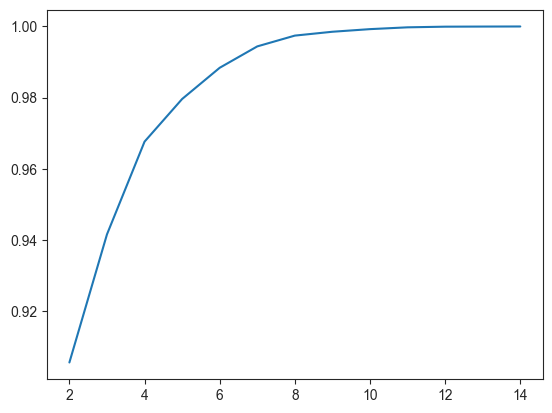

In [21]:
# plotting variance ratio
pd.Series(var_ratio).plot()

### Choosing PCA` n_components` and Kmeans `n_clusters` based on Clustering metrics

In [22]:
# apply PCA and display clustering metrics
from sklearn.cluster import KMeans
for y in range(2, 8):
    print("PCA with # of components: ", y)
    pca = PCA(n_components=y)
    data_p = pca.fit_transform(dfscaled)
    for cluster in range(2, 7):
        x = cluster
        kmeans = KMeans(n_clusters = x,)
        label = kmeans.fit_predict(data_p)
        print('Silhouette-Score for', x,  'Clusters: ', silhouette_score(data_p, label) , '-  Inertia: ',kmeans.inertia_)
    print()

PCA with # of components:  2
Silhouette-Score for 2 Clusters:  0.6385812330880528 -  Inertia:  92.81892580085157
Silhouette-Score for 3 Clusters:  0.567977417640593 -  Inertia:  45.65203262550851
Silhouette-Score for 4 Clusters:  0.5494710207659684 -  Inertia:  26.39515432068344
Silhouette-Score for 5 Clusters:  0.4999496231199864 -  Inertia:  23.732402296568406
Silhouette-Score for 6 Clusters:  0.4656249132029989 -  Inertia:  14.714034743175105

PCA with # of components:  3
Silhouette-Score for 2 Clusters:  0.6079529422598033 -  Inertia:  108.04150144408985
Silhouette-Score for 3 Clusters:  0.5101398583635125 -  Inertia:  60.41725757385557
Silhouette-Score for 4 Clusters:  0.4320405777230602 -  Inertia:  44.46335057715756
Silhouette-Score for 5 Clusters:  0.41904635815246355 -  Inertia:  31.219575323081145
Silhouette-Score for 6 Clusters:  0.3890330508549127 -  Inertia:  31.13510932716631

PCA with # of components:  4
Silhouette-Score for 2 Clusters:  0.5922193702248627 -  Inertia:  1

In [23]:
# Reducing the dimensions of the data 
pca_final=PCA(n_components=2,random_state=42).fit(dfscaled)

reduced=pca_final.fit_transform(dfscaled)

In [24]:
pcadf = pd.DataFrame(reduced) 
pcadf.columns = ['PC1', 'PC2'] 
  
pcadf.head(10)

,PC1,PC2
0,-4.230954,1.923638
1,-4.410466,1.254331
2,-4.062792,1.726370
3,-4.148301,0.804644
4,-3.150946,1.256610
5,-2.947855,1.095337
6,-3.225143,-0.012709
7,-3.055477,0.360620
8,-2.679308,0.510834
9,-2.531619,0.147657


In [25]:
pca_final.explained_variance_ratio_

array([0.82642142, 0.07918218])

# Elbow method to find best K-means clustering

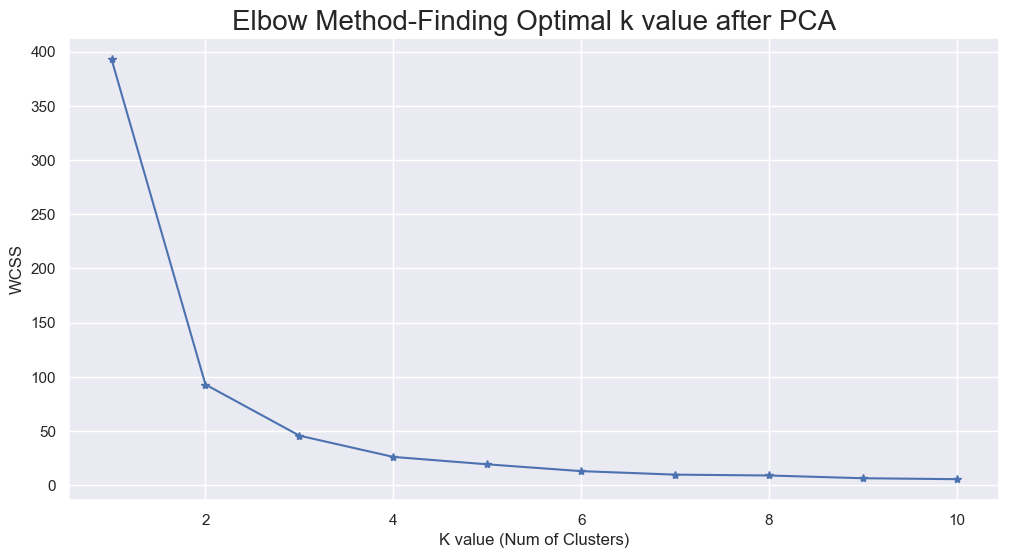

In [26]:
# model building, elbow method
wcss= {}
sns.set()
plt.figure(figsize=(12,6))
for i in range(1,11): 
    km = KMeans(n_clusters=i)
    km.fit(pcadf)
    wcss[i]=km.inertia_

plt.plot(range(1,11),wcss.values(), marker='*')
plt.title('Elbow Method-Finding Optimal k value after PCA', fontsize =20)
plt.xlabel('K value (Num of Clusters)')
plt.ylabel('WCSS')
plt.show()

For n_clusters = 3 The average silhouette_score is : 0.567977417640593
For n_clusters = 4 The average silhouette_score is : 0.5329746899889908
For n_clusters = 5 The average silhouette_score is : 0.47263146979257425
For n_clusters = 6 The average silhouette_score is : 0.5109838244737858


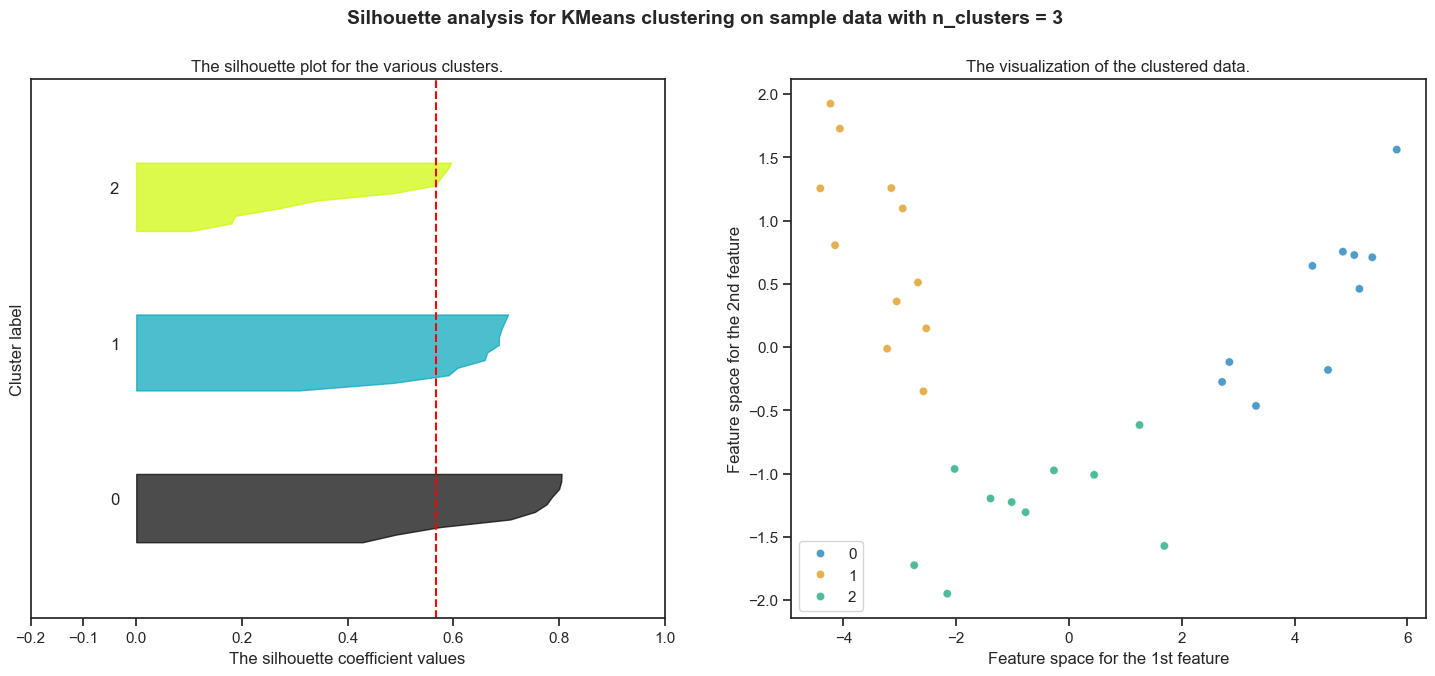

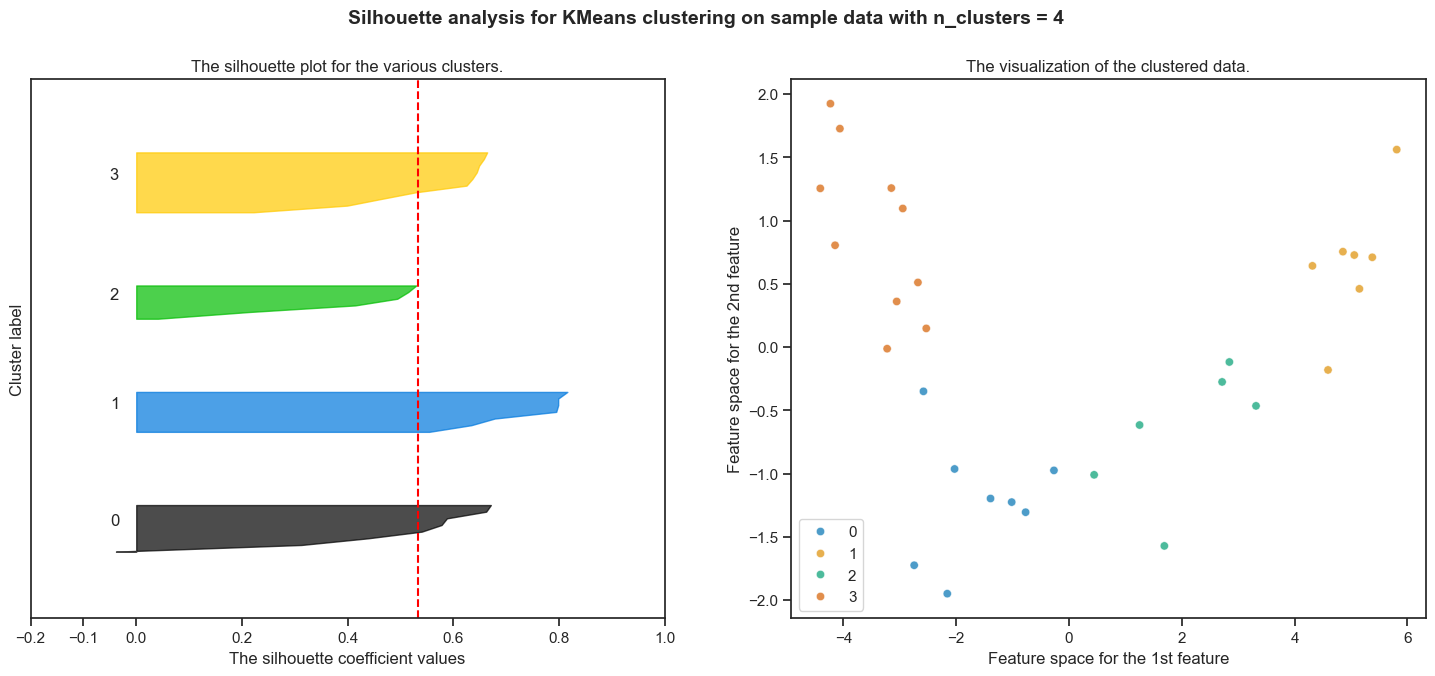

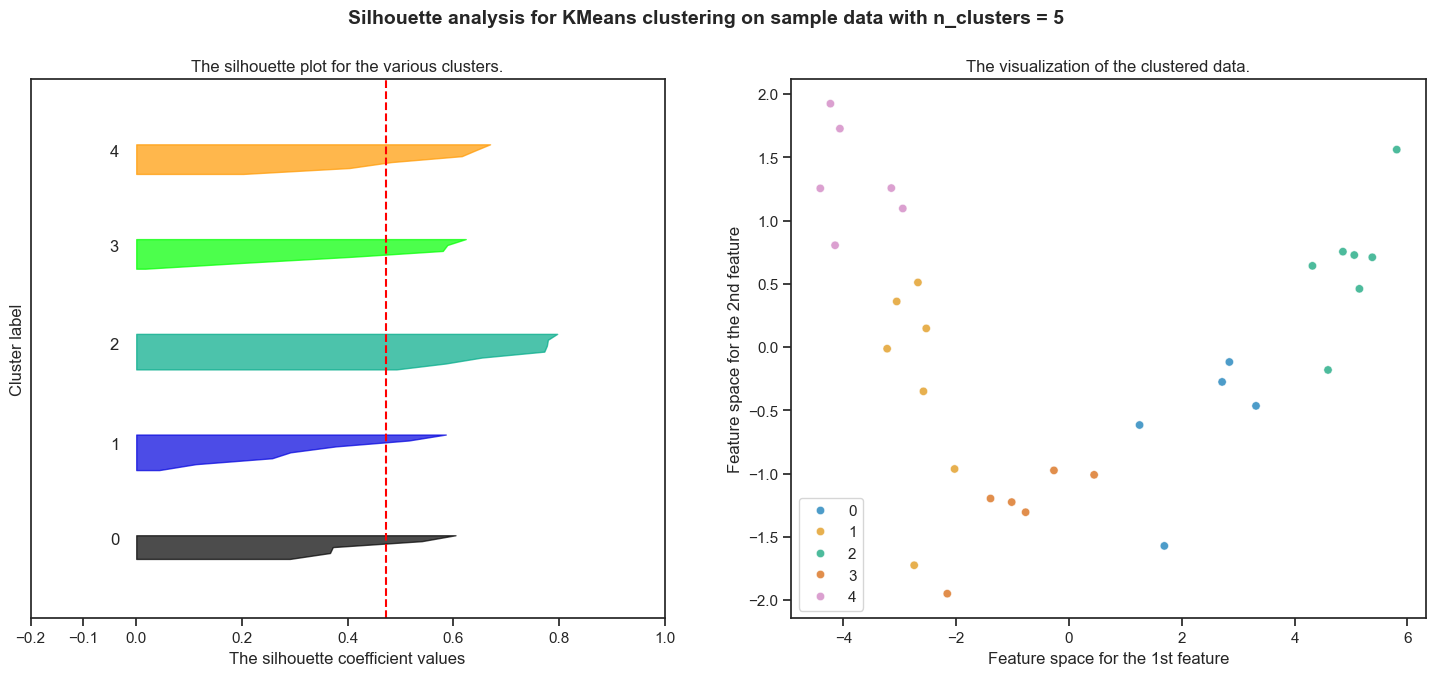

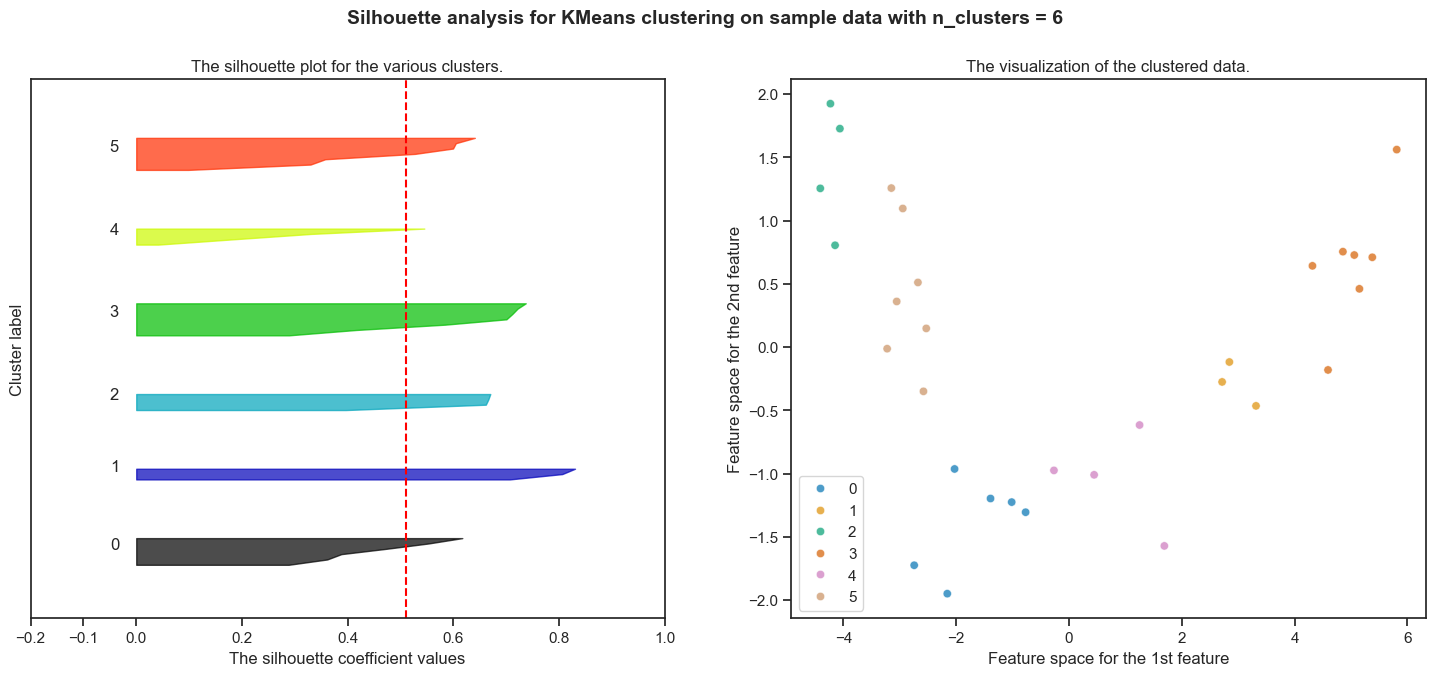

In [27]:
# We plot silhoutte score for Kmeans
# Here pcadf is pca dataframe, and Reduced is array of data after PCA.
sns.set_style('ticks')
silhouette_plot(KMeans,range(3,7), pcadf, reduced)

# Applying K-means with 3 clusters

In [28]:
# Fitting the model to reduced data
model = KMeans(n_clusters=3).fit(pcadf)
model_label = model.labels_
model_centers = model.cluster_centers_

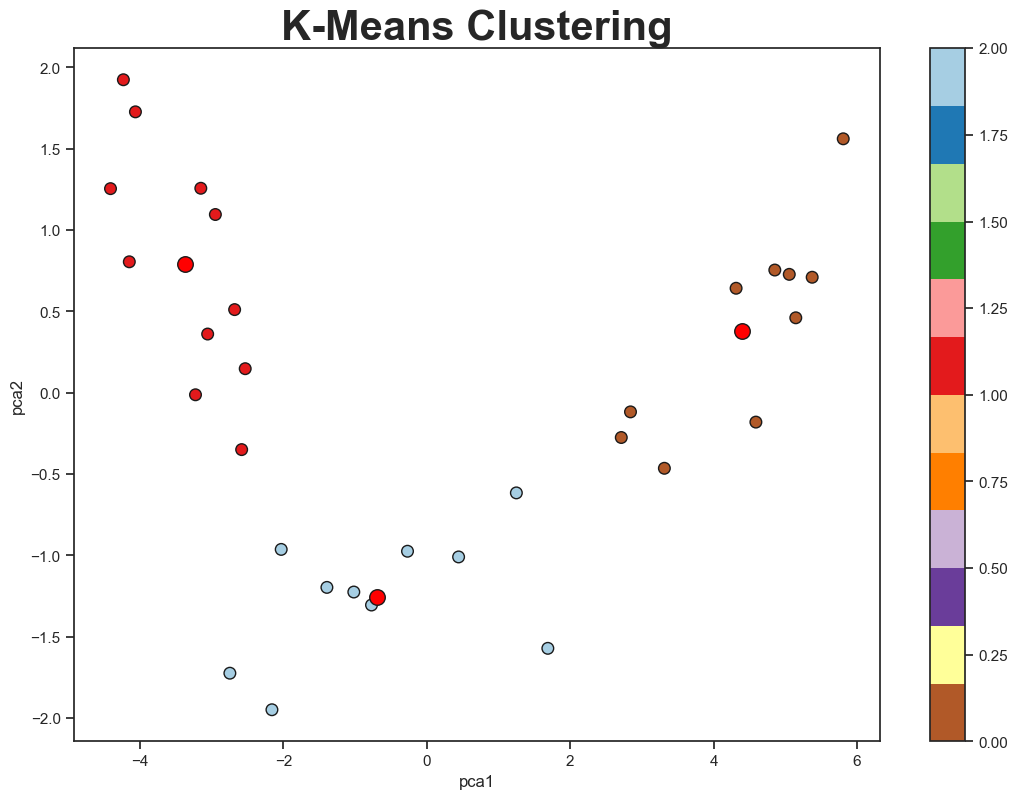

In [32]:
#Plotting the clusters
plt.figure(figsize=(13,9))
plt.title('K-Means Clustering', weight='bold', size=30)
plt.xlabel('pca1')
plt.ylabel('pca2')
scatter = plt.scatter(pcadf['PC1'], pcadf['PC2'], c=model_label, s=70, cmap='Paired_r', ec='k')
plt.colorbar(scatter)
plt.scatter(model_centers[:,0], model_centers[:,1], c='red', marker='.',s=500, ec='k');